In [1]:
#Importation des librairies nécessaires 

import numpy as np
import pandas as pd
import datetime as dt 
import yfinance as yf 
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
# Réglage d'une plage de temps pour un certain nombre d'années

années = 15

datefin = dt.datetime.now()

datedébut = datefin - dt.timedelta(days = 365 * années)

In [3]:
# Création d'une liste de tickers 

tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']

In [4]:
# Cours de clôture ajustés quotidiennement pour les tickers  ( ajustés car ils prennent en compte les dividendes et stock splits)

cloture_aj_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start = datedébut, end = datefin)
    cloture_aj_df[ticker] = data['Adj Close']

    
print(cloture_aj_df)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2008-10-27   62.827522  47.649967   72.180000   25.096781   31.531340
2008-10-28   70.169258  47.281452   73.790001   27.869762   34.696529
2008-10-29   69.660324  47.624107   74.000000   27.799776   34.349869
2008-10-30   72.070168  47.307285   72.709999   28.727026   35.510437
2008-10-31   72.466812  47.281452   71.339996   28.770761   36.294205
...                ...        ...         ...         ...         ...
2023-10-16  436.040009  69.089996  177.960007  369.410004  216.009995
2023-10-17  436.019989  6

In [6]:
# calcul des rendements journaliers en log  et suppression de tous les NA.

rendements_log  = np.log(cloture_aj_df/ cloture_aj_df.shift(1))
rendements_log  = rendements_log.dropna()

print(rendements_log)


                 SPY       BND       GLD       QQQ       VTI
Date                                                        
2008-10-28  0.110517 -0.007764  0.022060  0.104803  0.095658
2008-10-29 -0.007279  0.007221  0.002842 -0.002514 -0.010041
2008-10-30  0.034009 -0.006675 -0.017586  0.032810  0.033228
2008-10-31  0.005488 -0.000546 -0.019022  0.001521  0.021831
2008-11-03  0.002887  0.007796 -0.003370 -0.002131 -0.003328
...              ...       ...       ...       ...       ...
2023-10-16  0.010466 -0.005197 -0.004877  0.011243  0.011547
2023-10-17 -0.000046 -0.006535  0.001853 -0.003281  0.001295
2023-10-18 -0.013415 -0.004380  0.014367 -0.013205 -0.014905
2023-10-19 -0.008825 -0.004399  0.012199 -0.009401 -0.009477
2023-10-20 -0.012364  0.003668  0.002727 -0.015030 -0.012442

[3771 rows x 5 columns]


In [15]:
# Création d'une fonction pour éstimer le rendements du portefeuille
# L'hypothèse que les rendements futurs dependent des rendements passés est ici impliquée

def rendement_esp(poids, rendements_log):
    return np.sum(rendements_log.mean()*poids)

In [10]:
#création d'une fonction pour l'éstimation de l'écart-type du portefeuille

def ecart_type(poids, matrice_cov):
    variance = poids.T @ matrice_cov @ poids
    return np.sqrt(variance)

In [12]:
# Création de la matrice de covariance 

matrice_cov = rendements_log.cov()
matrice_cov

,SPY,BND,GLD,QQQ,VTI
SPY,0.000148,-1.749047e-06,0.000010,1.555066e-04,0.000150
BND,-0.000002,9.375557e-06,0.000009,-9.977354e-07,-0.000002
GLD,0.000010,8.657989e-06,0.000107,1.040976e-05,0.000011
QQQ,0.000156,-9.977354e-07,0.000010,1.892957e-04,0.000158
VTI,0.000150,-1.592087e-06,0.000011,1.582392e-04,0.000153


In [16]:
# Création d'un portefeuille équipondéré et l'ésperance de rendement ainsi que l'écart-tpe du portefeuille

valeur_portefeuille = 1000000
poids = np.array([1/len(tickers)]*len(tickers))
esp_rend_port = rendement_esp(poids, rendements_log)
ecart_type_port = ecart_type(poids, matrice_cov)

In [17]:
# Création d'une fonction qui donne un Z-Score aléatoire basé sur la loi normale

def z_score_aleatoire():
    return np.random.normal(0,1)



In [39]:
# Création d'une fonction de scenario Gain Perte

jours = 20

def scenario_gain_perte(valeur_portefeuille, ecart_type_port, z_score, jours):
    return valeur_portefeuille * esp_rend_port * jours + valeur_portefeuille * ecart_type_port *z_score *np.sqrt(jours)

In [40]:
# 10000 Scénarios

simulations = 10000
rendement_scenario = []

for i in range(simulations): 
    z_score = z_score_aleatoire()
    rendement_scenario.append(scenario_gain_perte(valeur_portefeuille, ecart_type_port, z_score, jours))


In [41]:
# Spécification d'un intervalle de confiance et calcul de la VaR

intervalle_conf = 0.99

VaR = -np.percentile(rendement_scenario, 100*(1 - intervalle_conf))

In [42]:
VaR

74456.806635487

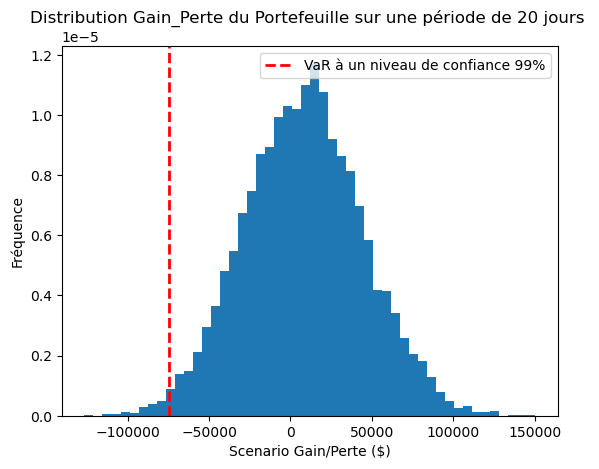

In [55]:
# Illustation des 10 000 scénarios 

plt.hist(rendement_scenario, bins = 50, density=True)
plt.xlabel('Scenario Gain/Perte ($)')
plt.ylabel('Fréquence')
plt.title(f"Distribution Gain_Perte du Portefeuille sur une période de {jours} jours ")
plt.axvline(-VaR, color='r', linestyle='dashed', linewidth=2, label=f"VaR à un niveau de confiance {intervalle_conf:.0%}")
plt.legend()
plt.show()